# Assignment 2
## Problem 1 a)

In [108]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf
%matplotlib inline

import tensorflow as tf
# GPU Check
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Step 1: Create Dataset based on functions

In [109]:
import math
# x between -1 and 1
def function_1(x: np.ndarray) ->np.ndarray :
    return x*np.sin(6*np.pi*x)*np.exp(-(x*x))

# x between -2 and 2
def function_2(x: np.ndarray) ->np.ndarray :
    return np.exp(-(x*x))*np.arctan(x)*np.sin(4*np.pi*x)

# import KFold from sklearn to help with the 10 fold cross validation
from sklearn.model_selection import KFold

# import tensorflow early stopping
from tensorflow.keras.callbacks import EarlyStopping

#  4 x 4 16 model assessment grid
# Data points
i = [10, 40, 80, 200] 

# Hidden nodes
j = [2, 10, 40, 100]

# create a random large data set of points
# generate data for function 1
data_x1 = np.random.uniform(-1, 1, 500)
data_x2 = np.random.uniform(-2, 2, 500)

datasets = [data_x1, data_x2]

# Large kernel initializer
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=100.0)

# Large bias initializer
bias_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=100.0)

# helper class for the regression models
class P1_model:

    def __init__(self, num_hidden_node: int, data_set_size: int, target_func: callable, function_label) -> None:

        self.num_hidden_node = num_hidden_node
        self.target_func = target_func
        self.data_set_size = data_set_size
        # 0 or 1 , 0 for fn 1 and 2 for fn 1
        self.function_label = function_label
        # self.model_history
        self.input_data = np.random.choice(datasets[function_label], size=data_set_size, replace=False)
        # self.target_data = self.target_func(self.input_data)

        # randomly shuffle the data
        self.random_indices = np.random.permutation(self.input_data.shape[0])
        self.input_data = self.input_data[self.random_indices]
        self.target_data = self.target_func(self.input_data)
        # separate data into 80% for training and 20% for testing
        
        self.input_data_train_and_val = self.input_data[: int(self.data_set_size * 0.8)]
        self.input_data_test = self.input_data[int(self.data_set_size * 0.8):]
        self.target_data_train_and_val = self.target_data[: int(self.data_set_size * 0.8)]
        self.target_data_test = self.target_data[int(self.data_set_size * 0.8):]

        self.best_train_loss = 100000
        self.best_val_loss = 100000
        self.mlp = tf.keras.models.Sequential([

        # input layer implicitly created

            tf.keras.layers.Dense(self.num_hidden_node, activation='tanh', input_shape=(1,), kernel_initializer=kernel_initializer,
    bias_initializer=bias_initializer),

    # activation='gelu'
    # activation='selu'
    # activation='elu
    # activation='swish'
    #  bias_initializer='uniform'),
    # kernel_initializer="uniform"
    # kernel_initializer="VarianceScaling"
    # tf.keras.initializers.TruncatedNormal(stddev=0.1)

    # try random normal

        # tf.keras.layers.Dense(1, activation='linear')
        tf.keras.layers.Dense(1, activation='linear')
        ])

        # for 10 data points, 1 option: divide folds in half
        # 2nd option: have 8 folds


        # keras layers have initialers
        # check bias-initializer and kernel initializer

        # usually set to low values by default
        # adjust/increase try standard deviation


        # print(self.input_data_train_and_val)
    
    def create_single_hidden_model(self):
        single_hidden = tf.keras.models.Sequential([
        tf.keras.layers.Dense(self.num_hidden_node, activation='tanh', input_shape=(1,),  kernel_initializer=kernel_initializer,
    bias_initializer=bias_initializer),
    # try random normal
        tf.keras.layers.Dense(1, activation='linear')
        ])

        return single_hidden

    
    def compile_mlp_model(self):
        # self.mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
         self.mlp.compile(optimizer="Adam", loss='mean_squared_error')
    
    def train_model(self):
        num_folds = 10
        if num_folds >= self.data_set_size:
            num_folds = int(self.data_set_size/2)
        else:
            num_folds = 10
    

        best_model = None
        best_val_loss = float('inf')

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        for index in range(5):
            kfold = KFold(n_splits=num_folds, shuffle=True)
            for train_index, val_index in kfold.split(self.input_data_train_and_val):
                input_data_train, input_data_val = self.input_data_train_and_val[train_index], self.input_data_train_and_val[val_index]
                target_data_train, target_data_val = self.target_data_train_and_val[train_index], self.target_data_train_and_val[val_index]
                
                # training 5 times like this is causing the notebook to crash after about an hour
                # model_history = test_model.fit(input_data_train, target_data_train, validation_data=(input_data_val, target_data_val), epochs=100, batch_size=1, callbacks=[early_stopping])
                
                # val_loss = np.average(model_history.history['val_loss'])
                # if val_loss < best_val_loss:
                #     best_val_loss = val_loss
                #     # best_model = self.mlp
                #     best_model = test_model
                #     best_history = model_history

        # moving training out of for loop to prevent crashes
        test_model = self.create_single_hidden_model()
        test_model.compile(optimizer='Adam', loss='mean_squared_error')

        model_history = test_model.fit(input_data_train, target_data_train, validation_data=(input_data_val, target_data_val), epochs=100, batch_size=1, callbacks=[early_stopping])

        val_loss = np.average(model_history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # best_model = self.mlp
            best_model = test_model
            best_history = model_history


        self.model_history = best_history
        # take the best model
        self.mlp = best_model
        self.best_train_loss = np.min(self.model_history.history['loss'])
        self.best_val_loss = np.min(self.model_history.history['val_loss'])
        # return best_model

    def plot_loss_history(self):

        plt.figure()
        plt.plot((self.model_history.history['loss']))
        plt.plot((self.model_history.history['val_loss']), 'r')
        # plt.plot(np.log10(self.model_history.history['loss']))
        # plt.plot(np.log10(self.model_history.history['val_loss']), 'r')
        plt.legend(['train loss', 'val loss'])
        plt.title(f"Function {self.function_label+1} Model: Data points: {self.data_set_size} Nodes: {self.num_hidden_node}")
        self.log()

    
    def log(self) -> None:
        print("mlp:", self.mlp)
        print("num_hidden_node:", self.num_hidden_node)
        print("dataset size:", self.data_set_size)
        print("target_func:", self.target_func)
        print("function label:", self.function_label)
        print("Best Val loss:", self.best_val_loss)
        print("Best Train loss:", self.best_train_loss)


In [110]:
models_1 = []
models_2 = []

# build the models
for hidden_nodes in j:
    for data_sizes in i:
        # create each model instance
        model1 = P1_model(hidden_nodes, data_sizes, function_1, 0)
        model2 = P1_model(hidden_nodes, data_sizes, function_2, 1)
        models_1.append(model1)
        models_2.append(model2)

In [111]:
# Inspect the models
for model in models_1:
    print(model.mlp.summary())

for model in models_2:
    print(model.mlp.summary())

Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 2)                 4         
                                                                 
 dense_257 (Dense)           (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 2)                 4         
                                                                 
 dense_261 (Dense)           (None, 1)                 3         
                                                                 
Total params: 7
Trainable par

In [112]:
# compile the models

# Inspect the models
for model in models_1:
    model.compile_mlp_model()

for model in models_2:
    model.compile_mlp_model()

In [113]:
# train all the models
for index, model in enumerate(models_1):
    # models_1[index] = 
    model.train_model()
    # print(model.train_model())

for index, model in enumerate(models_2):
    # models_2[index] = 
    model.train_model()
    # print(model.train_model())

Epoch 1/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0759 - val_loss: 0.0612
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0692 - val_loss: 0.0526
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0455
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0398
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0509 - val_loss: 0.0345
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0293
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0246
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0212
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0382 - val_loss: 0.0177
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0356 - val_loss: 0.0151
Epoch 11/100
7/7 [==========

mlp: <keras.engine.sequential.Sequential object at 0x0000021B97E9A208>
num_hidden_node: 2
dataset size: 10
target_func: <function function_1 at 0x0000021B976980D8>
function label: 0
Best Val loss: 0.0010375988204032183
Best Train loss: 0.026230577379465103
None
mlp: <keras.engine.sequential.Sequential object at 0x0000021B92A67FC8>
num_hidden_node: 2
dataset size: 40
target_func: <function function_1 at 0x0000021B976980D8>
function label: 0
Best Val loss: 0.04229770228266716
Best Train loss: 0.06340999156236649
None
mlp: <keras.engine.sequential.Sequential object at 0x0000021B93DA82C8>
num_hidden_node: 2
dataset size: 80
target_func: <function function_1 at 0x0000021B976980D8>
function label: 0
Best Val loss: 0.08368261903524399
Best Train loss: 0.05896194279193878
None
mlp: <keras.engine.sequential.Sequential object at 0x0000021B93DC1948>
num_hidden_node: 2
dataset size: 200
target_func: <function function_1 at 0x0000021B976980D8>
function label: 0
Best Val loss: 0.0716150552034378
Bes

c:\Users\Riyad\miniconda3\envs\ece457b\lib\site-packages\ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


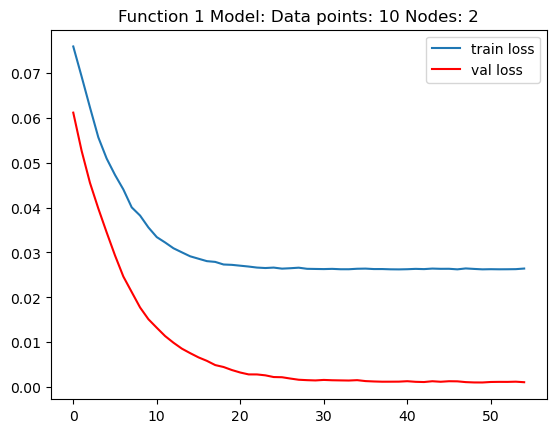

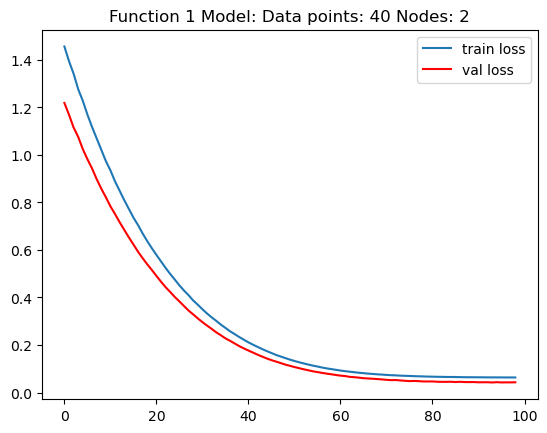

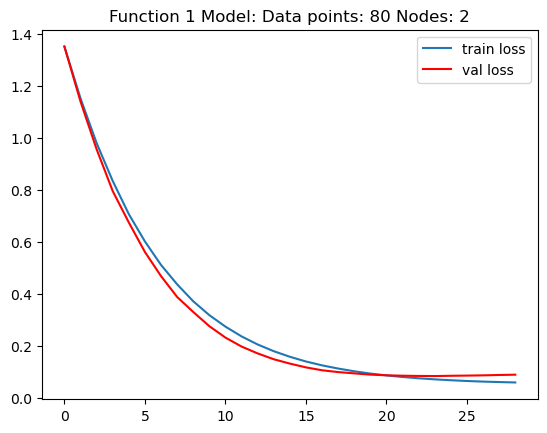

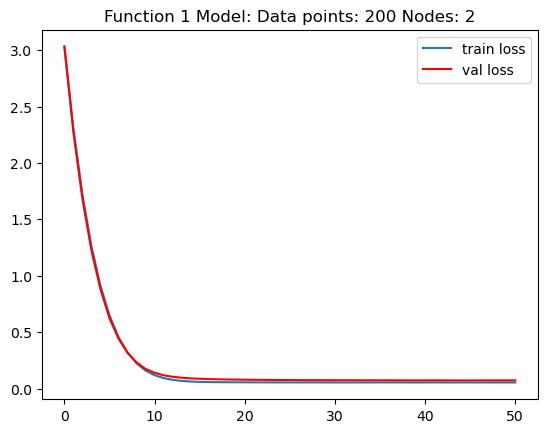

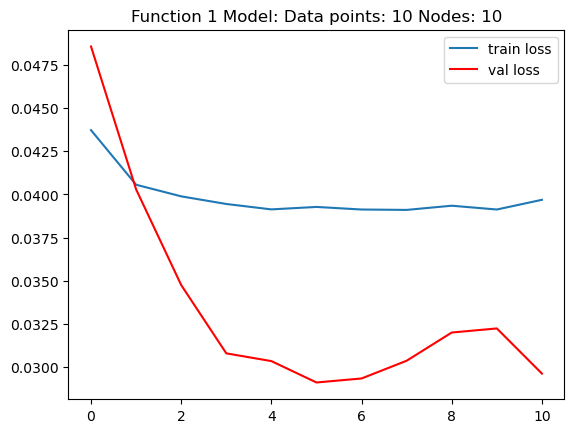

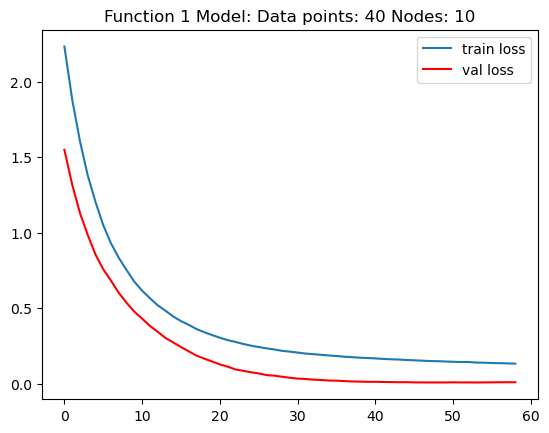

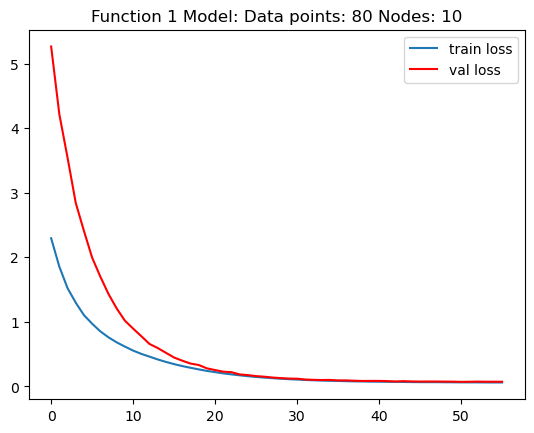

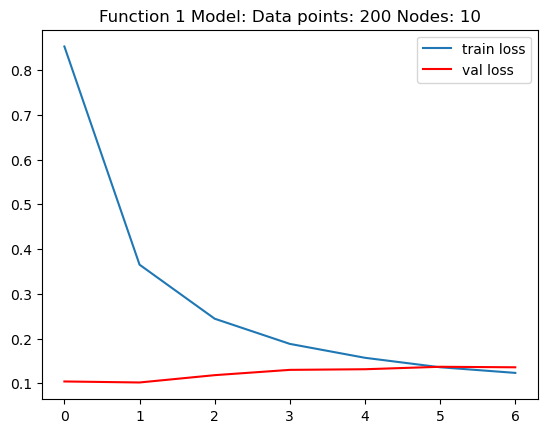

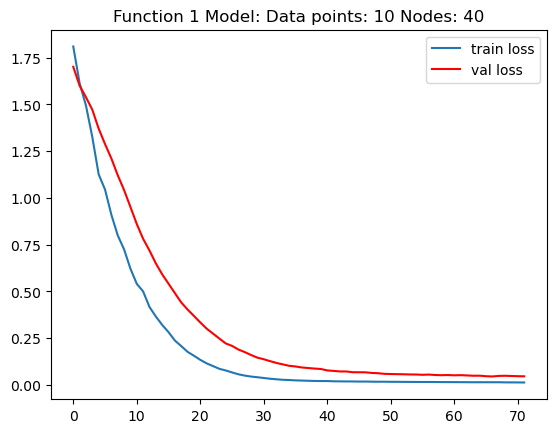

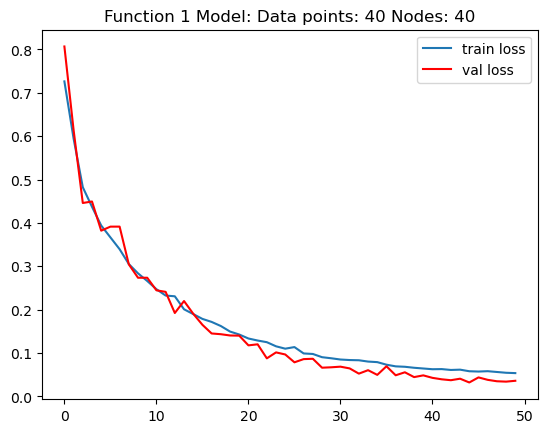

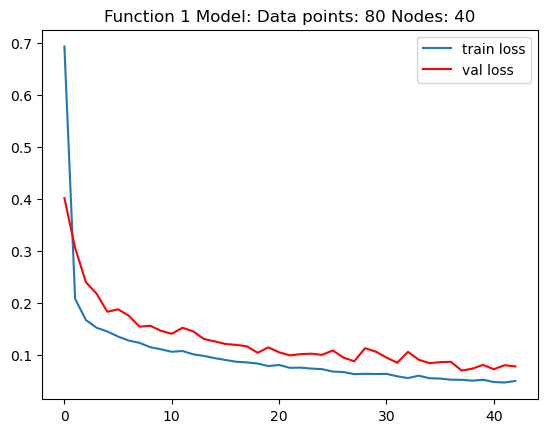

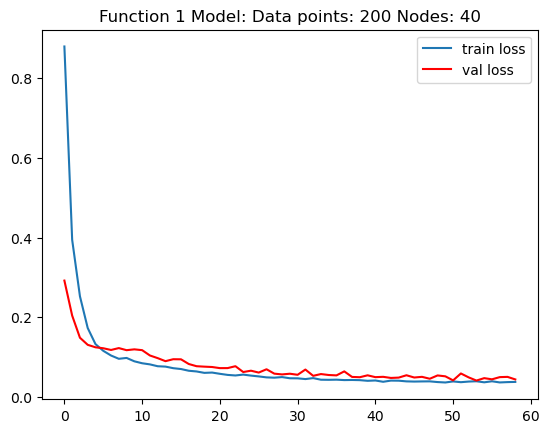

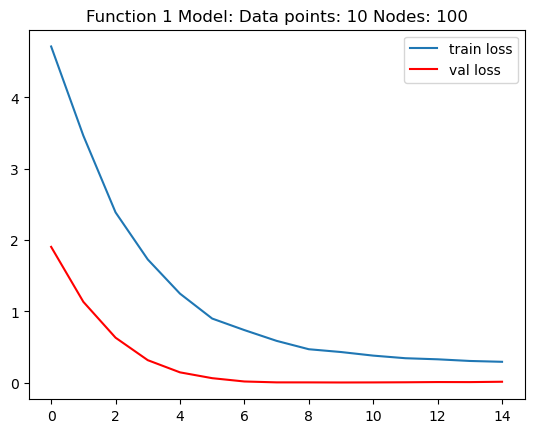

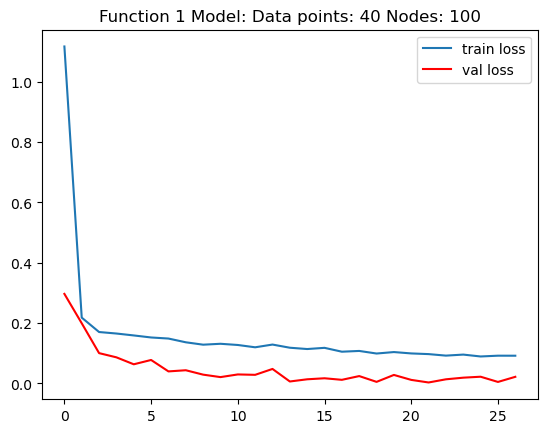

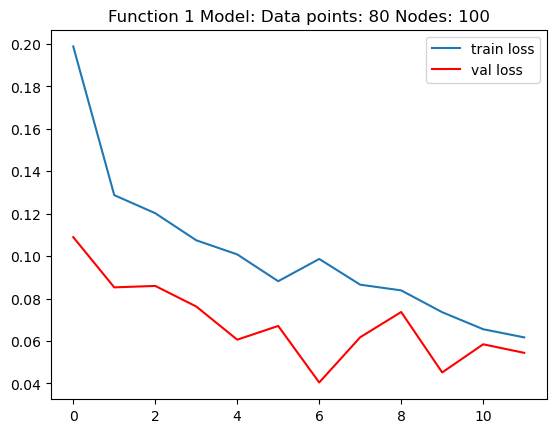

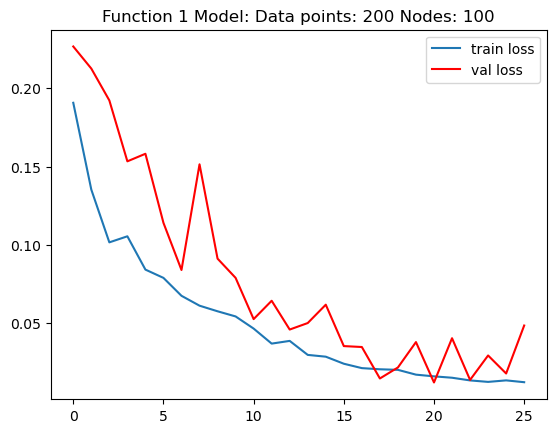

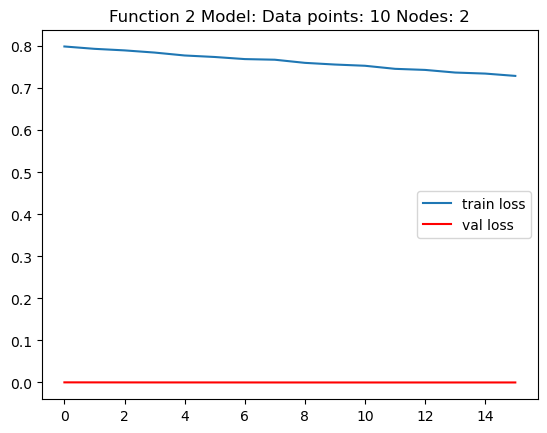

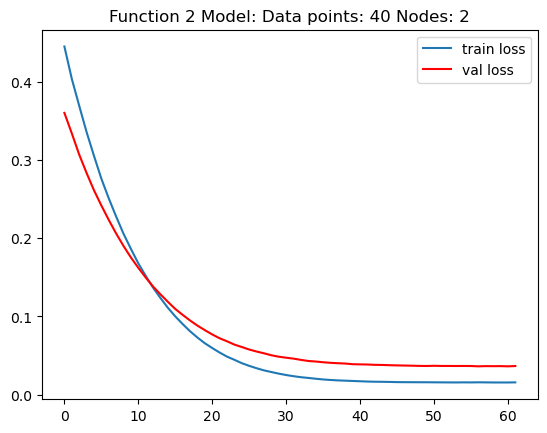

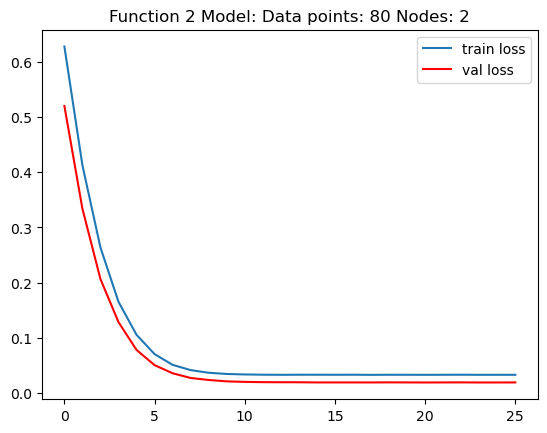

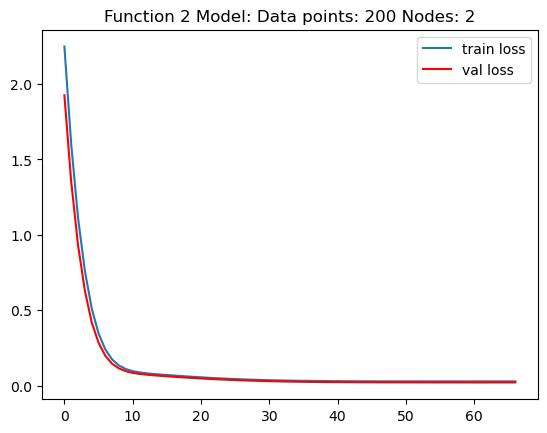

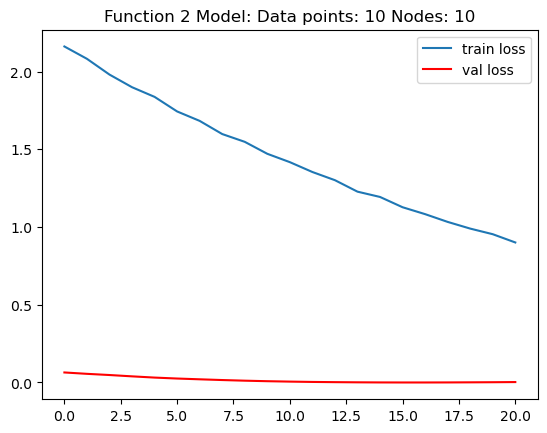

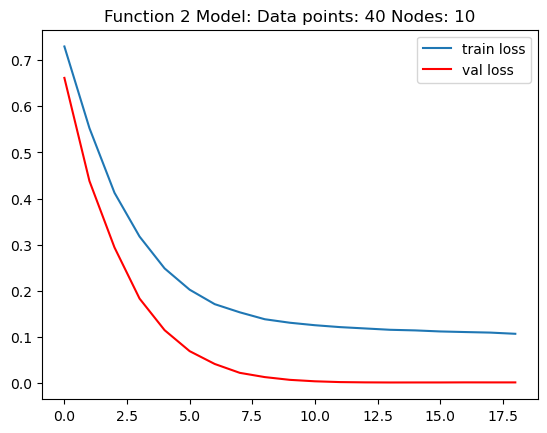

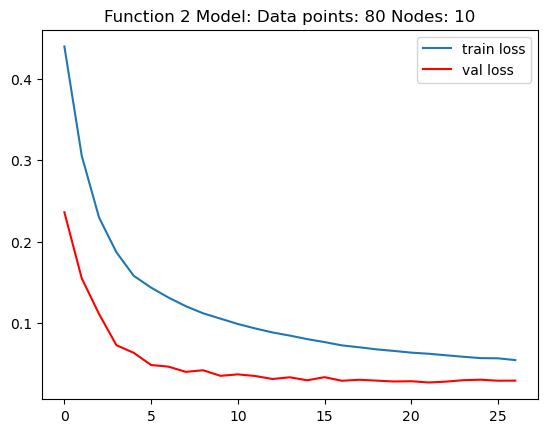

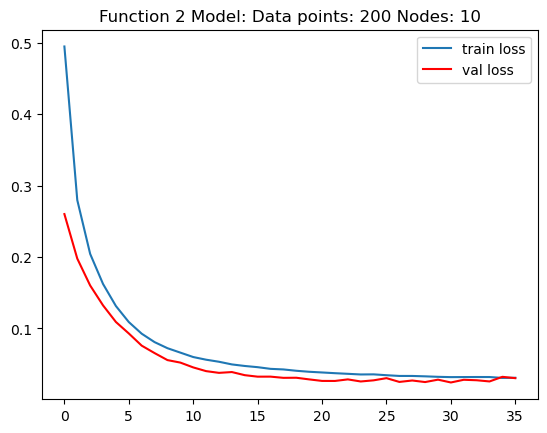

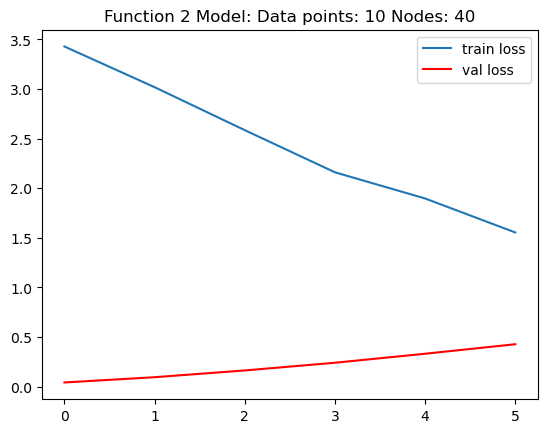

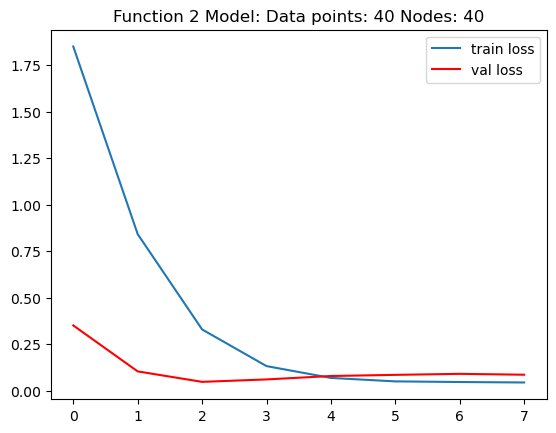

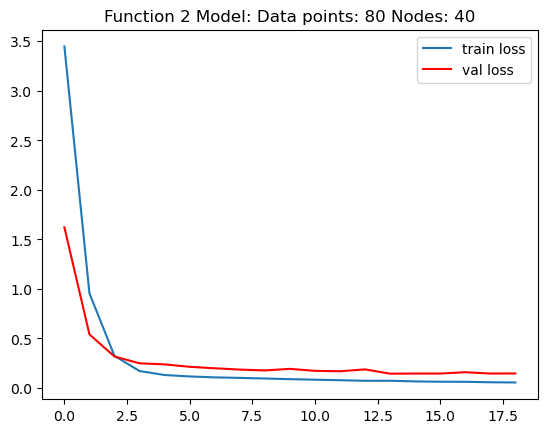

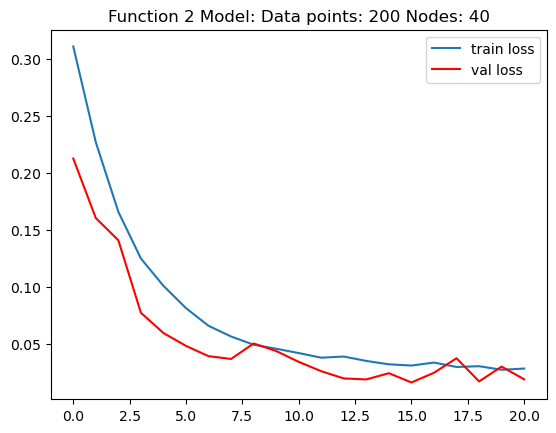

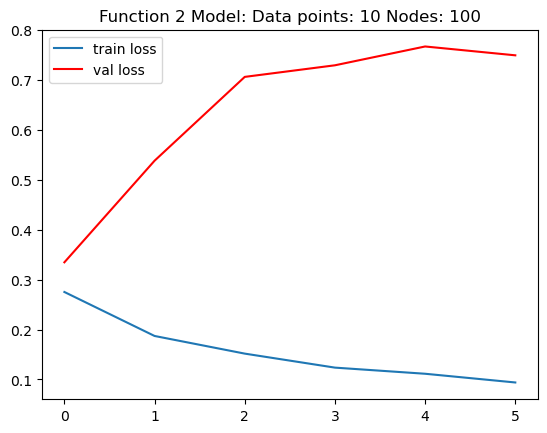

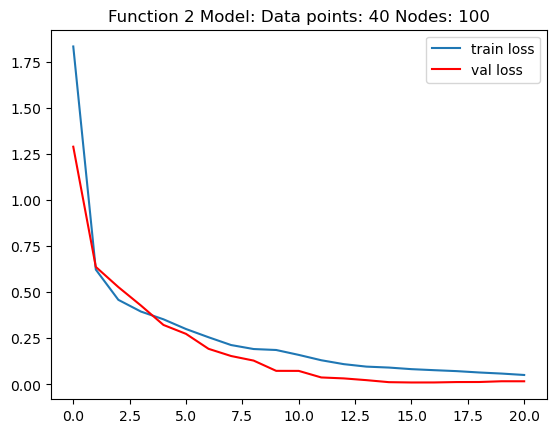

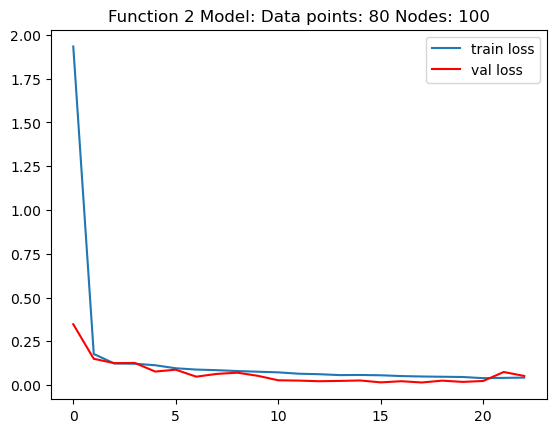

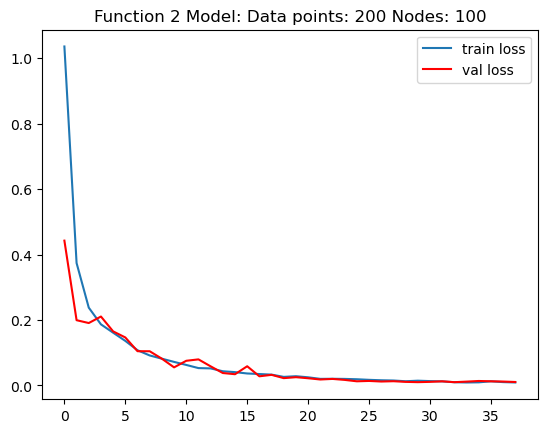

In [114]:
# check the graphs
for model in models_1:
    print(model.plot_loss_history())

for model in models_2:
    print(model.plot_loss_history())

# Visualization

In [184]:
# Evaluate models with test sets
((models_1[11].log()))
((models_2[15].log()))
# print(models_1[0].input_data_test)
# print('Test accuracy: %.2f %%'%(100*models_1[4].mlp.evaluate(models_1[4].input_data_test, models_1[4].target_data_test, verbose=0)[1]))


mlp: <keras.engine.sequential.Sequential object at 0x0000021B93DB8AC8>
num_hidden_node: 40
dataset size: 200
target_func: <function function_1 at 0x0000021B976980D8>
function label: 0
Best Val loss: 0.041222285479307175
Best Train loss: 0.03642380237579346
mlp: <keras.engine.sequential.Sequential object at 0x0000021B8CECA2C8>
num_hidden_node: 100
dataset size: 200
target_func: <function function_2 at 0x0000021B8D0B73A8>
function label: 1
Best Val loss: 0.009874575771391392
Best Train loss: 0.008962580002844334


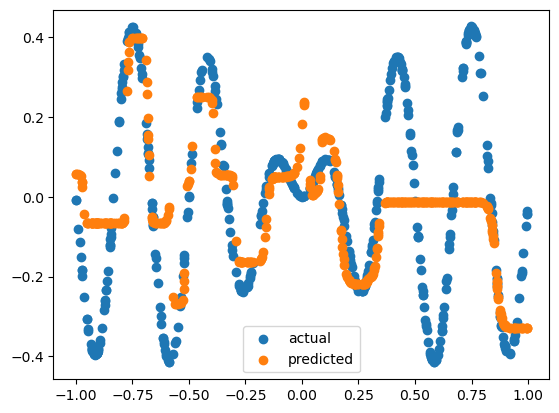

mse: 0.07957901


In [203]:
# Plot full dataset
actual = function_1(data_x1)
prediction = models_1[11].mlp(data_x1)
plt.scatter(data_x1, actual, label='actual')
plt.scatter(data_x1, prediction, label='predicted')
plt.legend()
plt.show()
mse = np.mean((prediction - actual)**2)

print("mse:", mse)

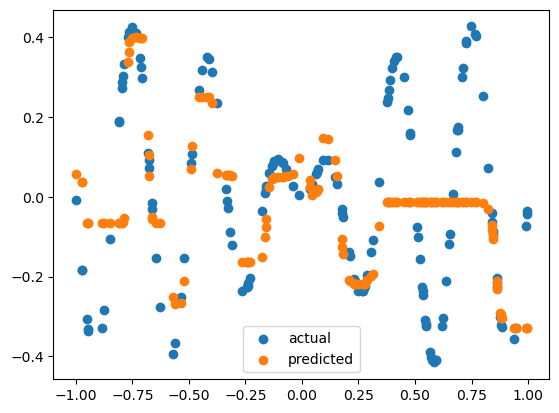

mse: 0.08222942


In [199]:
# check training data
data = models_1[11].input_data_train_and_val
actual = function_1(data)
prediction = models_1[11].mlp(data)
plt.scatter(data, actual, label='actual')
plt.scatter(data, prediction, label='predicted')
plt.legend()
plt.show()
mse = np.mean((prediction - actual)**2)
print("mse:", mse)

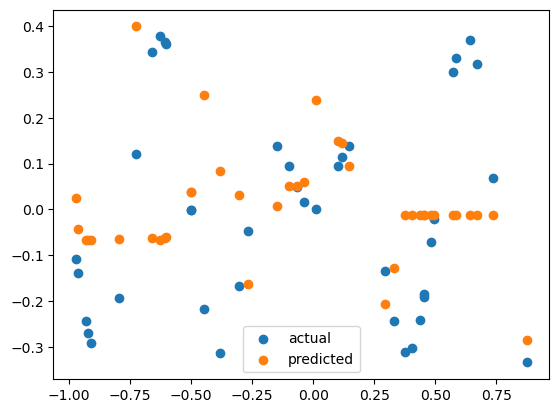

mse: 0.06475029


In [167]:
# evaluate with test data
test_data = models_1[11].input_data_test
actual = function_2(test_data)
prediction = models_1[11].mlp(test_data)
plt.scatter(test_data , actual, label='actual')
plt.scatter(test_data , prediction, label='predicted')
plt.legend()
plt.show()

mse = np.mean((prediction - actual)**2)
print("mse:", mse)

# Function 2

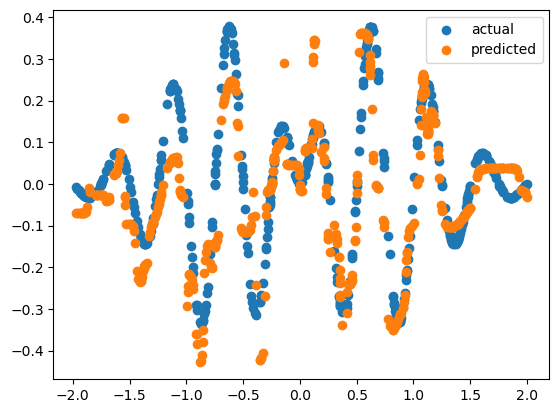

mse: 0.058293905


In [198]:
prediction = models_2[15].mlp(data_x2)
actual = function_2(data_x2)
plt.scatter(data_x2, actual, label='actual')
plt.scatter(data_x2,  prediction, label='predicted')
plt.legend()
plt.show()

mse = np.mean((prediction - actual)**2)
print("mse:", mse)

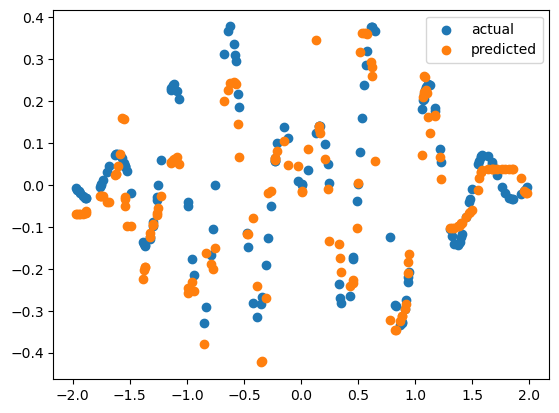

mse: 0.05899398


In [151]:
prediction = models_2[15].mlp(data)
actual = function_2(data)
# check with training data
data = models_2[15].input_data_train_and_val
plt.scatter(data, actual, label='actual')
plt.scatter(data, prediction, label='predicted')
plt.legend()
plt.show()

mse = np.mean((prediction - actual)**2)
print("mse:", mse)

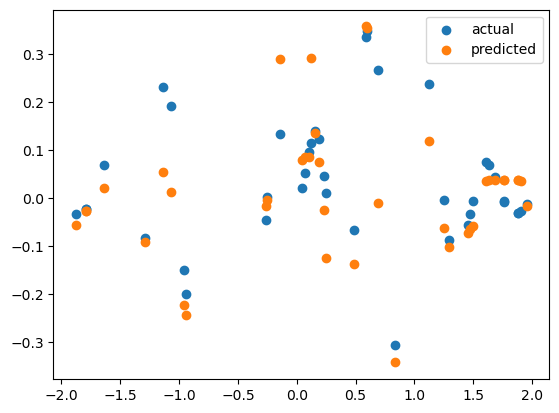

mse: 0.037299525


In [155]:
# evaluate with test data
prediction = models_2[15].mlp(test_data)
actual = function_2(test_data)
test_data = models_2[15].input_data_test
plt.scatter(test_data , actual, label='actual')
plt.scatter(test_data , prediction, label='predicted')
plt.legend()
plt.show()

mse = np.mean((prediction - actual)**2)
print("mse:", mse)